In [3]:
# default_exp data.processing.tf_data

%reload_ext autoreload
%autoreload 2

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.2.0'

In [3]:
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

# tf.data: Build TensorFlow input pipelines
https://tensorflow.google.cn/guide/data

使用tf.data API，您可以从简单，可重用的片段中构建复杂的输入管道。 

## 感觉和spark的rdd很像！

例如，图像模型的管道可能会聚集来自分布式文件系统中文件的数据，对每个图像应用随机扰动，然后将随机选择的图像合并为一批进行训练。 

文本模型的管道可能涉及从原始文本数据中提取符号，将它们转换为带有查找表的嵌入标识符，以及将不同长度的序列分批处理。 

tf.data API使处理大量数据，从不同数据格式读取数据以及执行复杂的转换成为可能。

tf.data API引入了tf.data.Dataset抽象，它表示a sequence of elements， in which each element consists of one or more components。 

For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label.

## 创建数据集有两种不同的方法：

A data source constructs a Dataset from data stored in memory or in one or more files.

A data transformation constructs a dataset from one or more tf.data.Dataset object

# Basic mechanics
要创建输入管道，您必须从数据源开始。 例如，要从内存中的数据构造数据集，可以使用tf.data.Dataset.from_tensors()或tf.data.Dataset.from_tensor_slices()。 或者，如果输入数据以推荐的TFRecord格式存储在文件中，则可以使用tf.data.TFRecordDataset()。

Once you have a Dataset object, you can transform it into a new Dataset by chaining method calls on the tf.data.Dataset object. For example, you can apply per-element transformations such as Dataset.map(), and multi-element transformations such as Dataset.batch(). 

See the documentation https://tensorflow.google.cn/api_docs/python/tf/data/Dataset for tf.data.Dataset for a complete list of transformations.

数据集对象是Python迭代的。 这使得可以使用for循环使用其元素：

In [4]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [5]:
for elem in dataset:
  print(elem.numpy())

8
3
0
8
2
1


In [6]:
# Or by explicitly creating a Python iterator using iter and consuming its elements using next:
it = iter(dataset)

print(next(it).numpy())

8


或者，可以使用reduce转换来消耗数据集元素，从而减少所有元素以产生单个结果。 以下示例说明了如何使用reduce转换来计算整数数据集的总和。

In [7]:
print(dataset.reduce(0, lambda state, value: state + value).numpy())

22


## Dataset structure
数据集包含每个具有相同（嵌套）结构的元素，并且该结构的各个组件可以是tf.TypeSpec可表示的任何类型，包括
* tf.Tensor，
* tf.sparse.SparseTensor，
* tf.RaggedTensor，
* tf.TensorArray， 
* 或tf.data.Dataset。

### Dataset.element_spec
Dataset.element_spec属性使您可以检查每个元素组件的类型。 该属性返回tf.TypeSpec对象的嵌套结构，该嵌套结构与元素的结构匹配，该元素可以是单个组件，组件的元组或组件的嵌套元组。 例如：

In [8]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))

dataset1.element_spec


TensorSpec(shape=(10,), dtype=tf.float32, name=None)

In [9]:
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

dataset2.element_spec

(TensorSpec(shape=(), dtype=tf.float32, name=None),
 TensorSpec(shape=(100,), dtype=tf.int32, name=None))

In [10]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3.element_spec


(TensorSpec(shape=(10,), dtype=tf.float32, name=None),
 (TensorSpec(shape=(), dtype=tf.float32, name=None),
  TensorSpec(shape=(100,), dtype=tf.int32, name=None)))

In [11]:
# Dataset containing a sparse tensor.
dataset4 = tf.data.Dataset.from_tensors(tf.SparseTensor(indices=[[0, 0], [1, 2]], values=[1, 2], dense_shape=[3, 4]))

dataset4.element_spec


SparseTensorSpec(TensorShape([3, 4]), tf.int32)

In [12]:
# Use value_type to see the type of value represented by the element spec
dataset4.element_spec.value_type


tensorflow.python.framework.sparse_tensor.SparseTensor

The Dataset transformations support datasets of any structure. When using the Dataset.map(), and Dataset.filter() transformations, which apply a function to each element, the element structure determines the arguments of the function:

In [13]:
dataset1 = tf.data.Dataset.from_tensor_slices(
    tf.random.uniform([4, 10], minval=1, maxval=10, dtype=tf.int32))

dataset1


<TensorSliceDataset shapes: (10,), types: tf.int32>

In [14]:
for z in dataset1:
  print(z.numpy())


[5 1 9 4 1 9 4 9 1 3]
[8 9 5 8 4 3 1 8 9 5]
[1 9 9 3 7 7 8 7 9 1]
[3 5 5 4 1 5 2 8 2 4]


In [15]:
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

dataset2


<TensorSliceDataset shapes: ((), (100,)), types: (tf.float32, tf.int32)>

In [16]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3


<ZipDataset shapes: ((10,), ((), (100,))), types: (tf.int32, (tf.float32, tf.int32))>

In [17]:
for a, (b,c) in dataset3:
  print('shapes: {a.shape}, {b.shape}, {c.shape}'.format(a=a, b=b, c=c))


shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)


# Reading input data
## Consuming NumPy arrays
If all of your input data fits in memory, the simplest way to create a Dataset from them is to convert them to tf.Tensor objects and use Dataset.from_tensor_slices().
### tf.data.Dataset.from_tensor_slices

In [18]:
train, test = tf.keras.datasets.fashion_mnist.load_data()


In [19]:
images, labels = train
images = images/255

In [21]:
images[:2], labels[:2]

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]), array([9, 0], dtype=uint8))

In [22]:
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset

<TensorSliceDataset shapes: ((28, 28), ()), types: (tf.float64, tf.uint8)>

## Consuming Python generators
Dataset.from_generator构造函数将python生成器转换为功能齐全的tf.data.Dataset。

构造函数将callable作为输入，而不是iterator。 This allows it to restart the generator when it reaches the end. It takes an optional args argument, which is passed as the callable's arguments.

之所以需要output_types参数，是因为tf.data在内部建立了tf.Graph，and graph edges require a tf.dtype。

In [23]:
def count(stop):
  i = 0
  while i<stop:
    yield i
    i += 1


In [24]:
ds_counter = tf.data.Dataset.from_generator(count, args=[25], output_types=tf.int32, output_shapes = (), )


In [25]:
for count_batch in ds_counter.repeat().batch(10).take(2):
  print(count_batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]


output_shapes参数不是必需的，但由于许多张量流操作不支持未知秩的张量，因此强烈建议使用它。 如果特定轴的长度未知或可变，则在output_shapes中将其设置为None。

同样重要的是要注意output_shapes和output_types遵循与其他数据集方法相同的嵌套规则。

这是一个示例生成器，演示了两个方面，它返回数组的元组，其中第二个数组是长度未知的向量。

In [26]:
def gen_series():
  i = 0
  while True:
    size = np.random.randint(0, 10)
    yield i, np.random.normal(size=(size,))
    i += 1


In [27]:
for i, series in gen_series():
  print(i, ":", str(series))
  if i > 2:
    break


0 : [ 1.3748  0.4379  1.4688  0.8562 -1.1617]
1 : [ 0.8218 -1.0554  0.8908  0.3475 -0.1519 -0.7465]
2 : [ 0.9398 -0.5283  0.7416 -0.6671 -0.2533 -0.3379  1.9267]
3 : []


The first output is an int32 the second is a float32.

The first item is a scalar, shape (), and the second is a vector of unknown length, shape (None,) 

In [28]:
ds_series = tf.data.Dataset.from_generator(
    gen_series, 
    output_types=(tf.int32, tf.float32), 
    output_shapes=((), (None,)))

ds_series


<FlatMapDataset shapes: ((), (None,)), types: (tf.int32, tf.float32)>

Now it can be used like a regular tf.data.Dataset. 

Note that when batching a dataset with a variable shape, you need to use Dataset.padded_batch.

In [29]:
ds_series_batch = ds_series.shuffle(20).padded_batch(10)

ids, sequence_batch = next(iter(ds_series_batch))
print(ids.numpy())
print()
print(sequence_batch.numpy())


[13  2 15 10 16  9 24 14 17 23]

[[ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.1734  1.9498 -0.4176  0.      0.      0.      0.    ]
 [-0.4754 -1.3482  0.8302 -2.3127  0.105   0.      0.    ]
 [-0.1826  1.7612  1.3715  1.4236  1.1111  0.6257 -0.1481]
 [ 1.0534  0.      0.      0.      0.      0.      0.    ]
 [-1.1127 -0.7522  0.5421  0.6989 -0.9074 -2.5534  0.    ]
 [-0.2712  1.888  -1.3051 -1.2236  0.      0.      0.    ]
 [ 1.5104  1.6771  0.      0.      0.      0.      0.    ]
 [-0.0504  0.0956 -0.7859  0.      0.      0.      0.    ]
 [ 0.7817 -1.0512  0.0188 -0.5319  0.022   1.2328  0.    ]]


# Batching dataset elements
## Simple batching
批处理的最简单形式是将数据集的n个连续元素堆叠为单个元素。 Dataset.batch（）转换正是使用与tf.stack（）运算符相同的约束来执行此操作，并将其应用于元素的每个组成部分：即，对于每个组成部分i，所有元素都必须具有完全相同形状的张量。

In [30]:
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
  print([arr.numpy() for arr in batch])


[array([0, 1, 2, 3]), array([ 0, -1, -2, -3])]
[array([4, 5, 6, 7]), array([-4, -5, -6, -7])]
[array([ 8,  9, 10, 11]), array([ -8,  -9, -10, -11])]
[array([12, 13, 14, 15]), array([-12, -13, -14, -15])]


当tf.data尝试传播形状信息时，Dataset.batch的默认设置会导致未知的批次大小，因为最后一个批次可能未满。 注意形状中的None：

In [31]:
batched_dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.int64)>

Use the drop_remainder argument to ignore that last batch, and get full shape propagation:

In [32]:
batched_dataset = dataset.batch(7, drop_remainder=True)
batched_dataset


<BatchDataset shapes: ((7,), (7,)), types: (tf.int64, tf.int64)>

## Batching tensors with padding
以上适用于所有大小均相同的张量。 

但是，许多模型（例如序列模型）都可以使用大小可变（例如长度不同的序列）的输入数据。 

为了处理这种情况，通过Dataset.padded_batch转换，您可以通过指定可以在其中填充的一个或多个维来批量处理不同形状的张量。

In [33]:
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
dataset = dataset.padded_batch(4, padded_shapes=(None,))

for batch in dataset.take(2):
  print(batch.numpy())
  print()



[[0 0 0]
 [1 0 0]
 [2 2 0]
 [3 3 3]]

[[4 4 4 4 0 0 0]
 [5 5 5 5 5 0 0]
 [6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]]



# Training workflows
## Processing multiple epochs
The tf.data API offers two main ways to process multiple epochs of the same data.

The simplest way to iterate over a dataset in multiple epochs is to use the Dataset.repeat() transformation. First, create a dataset of titanic data:

In [35]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)


In [36]:
def plot_batch_sizes(ds):
  batch_sizes = [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')


应用不带参数的Dataset.repeat（）转换将无限期地重复输入。

Dataset.repeat转换将其参数连接起来，而没有发信号通知一个时期的结束和下一个时期的开始。 因此，在Dataset.repeat之后应用的Dataset.batch将产生跨越epoch边界的批处理：

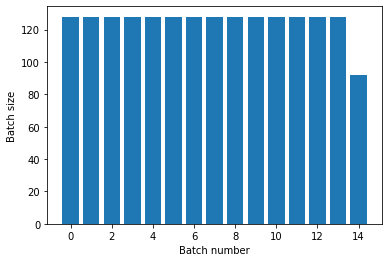

In [39]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)


If you need clear epoch separation, put Dataset.batch before the repeat:

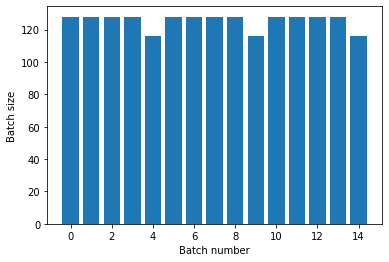

In [40]:
titanic_batches = titanic_lines.batch(128).repeat(3)

plot_batch_sizes(titanic_batches)


如果你想在每个epoch结束时执行自定义计算(例如收集统计数据)，那么最简单的方法就是在每个epoch上重新启动数据集迭代

In [41]:
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
  for batch in dataset:
    print(batch.shape)
  print("End of epoch: ", epoch)


(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


## Randomly shuffling input data
The Dataset.shuffle() transformation maintains a fixed-size buffer and chooses the next element uniformly at random from that buffer.

Note: While large buffer_sizes shuffle more thoroughly, they can take a lot of memory, and significant time to fill. Consider using Dataset.interleave across files if this becomes a problem.

Add an index to the dataset so you can see the effect:



In [42]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset


<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.string)>

由于buffer_size为100，而批大小为20，因此第一批不包含索引大于120的元素。

In [43]:
n,line_batch = next(iter(dataset))
print(n.numpy())


[ 91  10  57  52   7  79  17  85  40  72 102 106  45  65  87  84  86 112
  77  15]


与Dataset.batch一样，相对于Dataset.repeat的顺序也很重要。

直到shuffle缓冲区为空时，Dataset.shuffle才发出信号以指示epoch结束。 因此，在shuffle之前放置repeat将显示一个epoch的每个元素，然后再移至下一个epoch：

In [44]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())


Here are the item ID's near the epoch boundary:

[561 588 580 612 489 619 545 593 594 497]
[487 625 541 482 563 510 611 527 566 604]
[548 435 560 616 552 597 585 599]
[ 30  15  69   1  50  59  60  88 106  25]
[ 18  39 102   7  10  27  92  87  91  67]


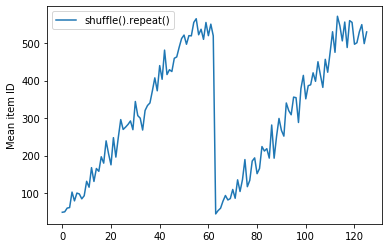

In [45]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()


But a repeat before a shuffle mixes the epoch boundaries together:

In [46]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
  print(n.numpy())


Here are the item ID's near the epoch boundary:

[466 599 610  15 517 487  26 398 396   6]
[612 584 533 508 277 440 369 581 313   2]
[481 627  12  23 547  25  34 595  11 625]
[565 562  17 334  16  22 416 594  57 603]
[ 28 375  38  14 582 550 549  31   5 408]
[  3  66  21  69 617  39 624 560 621  54]
[586  33  41  49  30  72  23  46  36  90]
[ 53   8  43 365 604  96 559 611 539 613]
[ 89  84  63 536  86 103   9  20  83 567]
[592 106  95  42  44 607  32 622  68  99]
[ 92  40  45 100 115  85  93 614 521 127]
[105   1  78  10  73 597  65 572  29 138]
[111 501  18 129 125 542 540 588 118 123]
[ 79 152 117 101 102 151 142  52 619  67]
[ 61 119  70  58 113 134 502  75 153 159]


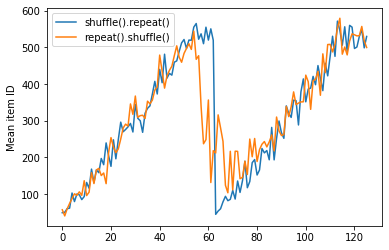

In [47]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()


# Preprocessing data
Dataset.map（f）转换通过将给定函数f应用于输入数据集的每个元素来生成新的数据集。 它基于map（）函数，该函数通常以函数式编程语言应用于列表（和其他结构）。 函数f接受表示输入中单个元素的tf.Tensor对象，并返回表示新数据集中的单个元素的tf.Tensor对象。 它的实现使用标准的TensorFlow operations将一个元素转换为另一个元素。

本节介绍如何使用Dataset.map（）的常见示例。
## Decoding image data and resizing it
在现实世界的图像数据上训练神经网络时，通常需要将不同大小的图像转换为通用大小，以便可以将它们批量处理为固定大小。

重建花的文件名数据集：

In [50]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)



In [51]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))


In [52]:
# Write a function that manipulates the dataset elements.
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label


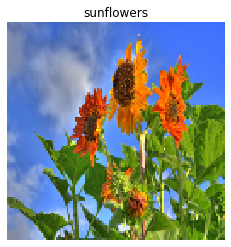

In [53]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

show(image, label)


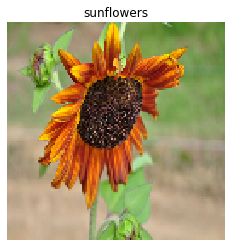

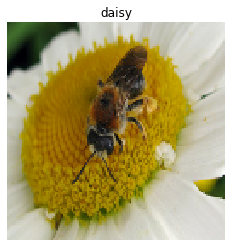

In [54]:
images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
  show(image, label)


## Applying arbitrary Python logic
For performance reasons, use TensorFlow operations for preprocessing your data whenever possible. However, it is sometimes useful to call external Python libraries when parsing your input data. You can use the tf.py_function() operation in a Dataset.map() transformation.

For example, if you want to apply a random rotation, the tf.image module only has tf.image.rot90, which is not very useful for image augmentation. 

# nb_export

In [2]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 00_template.ipynb.
Converted active_learning.ipynb.
Converted algo_dl_keras.ipynb.
Converted algo_ml_eda.ipynb.
Converted algo_ml_tree_catboost.ipynb.
Converted algo_ml_tree_lgb.ipynb.
Converted algo_rs_associated_rules.ipynb.
Converted algo_rs_match_deepmatch.ipynb.
Converted algo_rs_matrix.ipynb.
Converted algo_rs_search_vector_faiss.ipynb.
Converted algo_seq_embeding.ipynb.
Converted algo_seq_features_extraction_text.ipynb.
Converted datastructure_dict_list_set.ipynb.
Converted datastructure_matrix_sparse.ipynb.
Converted engineering_concurrency.ipynb.
Converted engineering_nbdev.ipynb.
Converted engineering_panel.ipynb.
Converted engineering_snorkel.ipynb.
Converted index.ipynb.
Converted math_func_basic.ipynb.
Converted math_func_loss.ipynb.
Converted operating_system_command.ipynb.
Converted plot.ipynb.
Converted utils_functools.ipynb.
Converted utils_json.ipynb.
Converted utils_pickle.ipynb.
Converted utils_time.ipynb.


In [7]:
!nbdev_build_docs

No notebooks were modified
converting /Users/luoyonggui/PycharmProjects/nbdevlib/index.ipynb to README.md
